In [91]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Importing the necessary python packages

In [92]:
import sys
sys.path.append('/home/jb07/python_modules/')

In [93]:
from ipywidgets import fixed, interact
import ipywidgets as widgets
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from scipy.stats import chisquare, mannwhitneyu, sem, shapiro, ttest_ind, zscore

Importing functions that are re-used through the analyses

In [94]:
import sys
sys.path.append('../code/')

In [95]:
from BrainTypes_analysis_functions import get_imaging_ID
from BrainTypes_analysis_functions import get_consensus_matrix, get_consensus_module_assignment
from BrainTypes_analysis_functions import plot_spring_layout, plot_community_matrix

Defining general setting for plotting

In [96]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
mm2inches = 0.039371
single_column = 90*mm2inches
double_column = 190*mm2inches
one_half_column = 140*mm2inches

## 1. Processing the diffusion-weighted data

This calls a script that submits the processing to a compute cluster with 'qsub'. The code for the processing pipeline is in 'BrainTypes_dwi_preproc.py'

In [50]:
user_input = raw_input('Run dwi preprocessing (y/n/)? ')

if user_input == 'y':
    !python ../code/BrainTypes_dwi_preproc_submission.py

Run dwi preprocessing (y/n/)? y
2562325.master01.mrc-cbsu.local
2562326.master01.mrc-cbsu.local
2562327.master01.mrc-cbsu.local
2562328.master01.mrc-cbsu.local
2562329.master01.mrc-cbsu.local
2562330.master01.mrc-cbsu.local
2562331.master01.mrc-cbsu.local
2562332.master01.mrc-cbsu.local
2562333.master01.mrc-cbsu.local
2562334.master01.mrc-cbsu.local
2562335.master01.mrc-cbsu.local
2562336.master01.mrc-cbsu.local
2562337.master01.mrc-cbsu.local
2562338.master01.mrc-cbsu.local
2562339.master01.mrc-cbsu.local
2562340.master01.mrc-cbsu.local
2562341.master01.mrc-cbsu.local
2562342.master01.mrc-cbsu.local
2562343.master01.mrc-cbsu.local
2562344.master01.mrc-cbsu.local
2562345.master01.mrc-cbsu.local
2562346.master01.mrc-cbsu.local
2562347.master01.mrc-cbsu.local
2562348.master01.mrc-cbsu.local
2562349.master01.mrc-cbsu.local
2562350.master01.mrc-cbsu.local
2562351.master01.mrc-cbsu.local
2562352.master01.mrc-cbsu.local
2562353.master01.mrc-cbsu.local
2562354.master01.mrc-cbsu.local
2562355.

Extracting movement and number of volumes from the FSL eddy output

In [ ]:
for study in ['CALM', 'NKI', 'ACE']:
    in_folder = '/imaging/jb07/CALM/BrainTypes/' + study + '/dwi_preproc/'
    filename = lambda subject: in_folder + '_subject_id_' + subject + '/eddy/eddy_corrected.eddy_movement_rms'
    subject_list = [subject.split('_')[-1] for subject in os.listdir(in_folder) if os.path.isfile(filename(subject.split('_')[-1]))]

    quality_df = []

    for subject in subject_list:
        max_movement = np.max(pd.read_csv(filename(subject), header=None, delim_whitespace =True)[1].values)
        n_volumes = nib.load('/'.join(filename(subject).split('/')[:-1]) + '/eddy_corrected.nii.gz').get_header().get_data_shape()[-1]
        quality_df.append({'MRI.ID': subject,
                           'movement': max_movement,
                           'volumes': n_volumes})

    quality_df = pd.DataFrame(quality_df).set_index('MRI.ID')
    quality_df.to_csv('../data/derived_data/' + study + '_movement.csv')

## 2. Getting FA values for each tract

In [171]:
def extract_FA_values_per_tract(in_folder, out_file, subject_list, prob_thresh):
    import nibabel as nib
    import numpy as np
    import os
    import pandas as pd
    import re

    filename = lambda subject:  in_folder + '_subject_id_' + subject + '/reg/' + subject + '_Warped.nii.gz'

    atlas = os.environ['FSLDIR'] + '/data/atlases/JHU/JHU-ICBM-tracts-maxprob-thr' + prob_thresh + '-1mm.nii.gz'
    atlas_data = nib.load(atlas).get_data()
    results = []

    for subject in subject_list:
        subject_img = nib.load(filename(subject))
        subject_data = subject_img.get_data()

        for tract in np.unique(atlas_data)[1:]:
            tract_data = atlas_data.copy()
            tract_data[tract_data == tract] = 100
            tract_data[tract_data < 100] = 0
            tract_data[tract_data == 100] = 1

            subject_tract = subject_data*tract_data
            tract_value = np.mean(subject_tract[subject_tract > 0])
            results.append({'ID': subject,
                             'tract': tract,
                             'FA': tract_value})

    results = pd.DataFrame(results)
    results.to_csv(out_file, index=False)

In [ ]:
for study in ['NKI', 'ACE', 'CALM']:
    in_folder = '/imaging/jb07/CALM/BrainTypes/' + study + '/dwi_preproc/'
    out_file = '../data/derived_data/' + study + '_FA_values_by_tract_50.csv'
    filename = lambda subject:  in_folder + '_subject_id_' + subject + '/reg/' + subject + '_Warped.nii.gz'
    subject_list = [subject.split('_')[-1] for subject in sorted(os.listdir(in_folder)) if os.path.isfile(filename(subject.split('_')[-1]))]
    extract_FA_values_per_tract(in_folder, out_file, subject_list, prob_thresh)

## 3. Descritpion of sample details

In the first step, the data from the three sampels used in this study are loaded. Then, general descriptions of the sample are provided, i.e. number of total files, number of useable files, gender split, and age ranges.

**NB**: Useable diffusion-weighted data is defined as dwi sequences with less than 3mm displacement between consecutive volumes as obtained through FSL eddy in the processing pipeline

**NKI sample**

In [203]:
nki_details = pd.read_csv('../data/raw_data/NKI_behavioural_data.csv')[['Unnamed: 0', 'AGE_04', 'DEM_002', 'VISIT']]
nki_details = nki_details.dropna()
nki_details.columns = ['ID', 'Age', 'Gender', 'Visit']
nki_details['Age'] = nki_details['Age'].astype('float')

In [204]:
print 'Total number of participants: n=%i' % len(np.unique(nki_details['ID']))

Total number of participants: n=117


In [205]:
nki_results = pd.read_csv('../data/derived_data/NKI_FA_values_by_tract_25.csv')
nki_details = nki_details[nki_details['ID'].isin(nki_results['ID'])]
nki_details = nki_details.drop_duplicates(subset='ID')
nki_results = nki_results[nki_results['ID'].isin(nki_details['ID'])]

In [206]:
print 'Number of useable files: n=%i' % len(np.unique(nki_results['ID']))
print 'Number of males: n=%i' %nki_details['Gender'].value_counts()[1]
print 'Age: mean=%.2f, SD=%.3f' % (np.mean(nki_details['Age']), np.std(nki_details['Age']))
print 'Age range: %.2f - %.2f' % (np.min(nki_details['Age']), np.max(nki_details['Age']))

Number of useable files: n=74
Number of males: n=43
Age: mean=13.93, SD=3.164
Age range: 6.97 - 21.58


In [207]:
nki_results['study'] = np.repeat('NKI', nki_results.shape[0])

**CALM sample**

In [208]:
motion_df = pd.read_csv('../data/derived_data/CALM_movement.csv')
motion_df.columns = ['ID', 'motion', 'volumes']

In [209]:
print 'Total number of participants: n=%i' % len(np.unique(motion_df['ID']))

Total number of participants: n=210


In [210]:
calm_results = pd.read_csv('../data/derived_data/CALM_FA_values_by_tract_25.csv')
calm_details = pd.read_csv('../data/raw_data/CALM_behavioural_data_Apr17.csv')[['ID No.', 'Gender(1=male)', 'Age_in_months']]
calm_details = calm_details.dropna()
calm_details['MRI.ID'] = [get_imaging_ID(str(int(ID)), '../data/raw_data/MRI_ID_match_Aug17.csv') for ID in calm_details['ID No.']]
calm_details = calm_details[calm_details['MRI.ID'].isin(calm_results['ID'])]
calm_details['Age'] = calm_details['Age_in_months']/12
calm_results = calm_results[calm_results['ID'].isin(calm_details['MRI.ID'].values)]

In [211]:
print 'Number of useable files: n=%i' % len(np.unique(calm_results['ID']))
print 'Number of males: n=%i' %calm_details['Gender(1=male)'].value_counts()[1]
print 'Age: mean=%.2f, SD=%.3f' % (np.mean(calm_details['Age']), np.std(calm_details['Age']))
print 'Age range: %.2f - %.2f' % (np.min(calm_details['Age']), np.max(calm_details['Age']))

Number of useable files: n=193
Number of males: n=133
Age: mean=9.62, SD=2.151
Age range: 5.50 - 17.92


In [212]:
calm_results['study'] = np.repeat('CALM', calm_results.shape[0])

**ACE sample**

In [213]:
motion_df = pd.read_csv('../data/derived_data/ACE_movement.csv')
motion_df.columns = ['ID', 'motion', 'volumes']

In [214]:
print 'Total number of participants: n=%i' % len(np.unique(motion_df['ID']))

Total number of participants: n=86


In [215]:
ace_results = pd.read_csv('../data/derived_data/ACE_FA_values_by_tract_25.csv')
ace_details = pd.read_csv('../data/raw_data/ACE_demographic_data.csv')
ace_details = ace_details.dropna()
ace_details = ace_details[ace_details['MRI.ID'].isin(ace_results['ID'])]
ace_details['Age'] = ace_details['Age']/12
ace_results = ace_results[ace_results['ID'].isin(ace_details['MRI.ID'].values)]

In [216]:
print 'Number of useable files: n=%i' % len(np.unique(ace_results['ID']))
print 'Number of males: n=%i' %ace_details['Gender'].value_counts()[1]
print 'Age: mean=%.2f, SD=%.3f' % (np.mean(ace_details['Age']), np.std(ace_details['Age']))
print 'Age range: %.2f - %.2f' % (np.min(ace_details['Age']), np.max(ace_details['Age']))

Number of useable files: n=86
Number of males: n=42
Age: mean=9.99, SD=1.508
Age range: 6.92 - 12.65


In [217]:
ace_results['study'] = np.repeat('ACE', ace_results.shape[0])


## 2. Looking for differences between the studies

In [192]:
labels = ['Anterior thalamic radiation L', 'Anterior thalamic radiation R', 'Corticospinal tract L', 'Corticospinal tract R', 'Cingulum (cingulate gyrus) L', 'Cingulum (cingulate gyrus) R', 'Cingulum (hippocampus) L', 'Cingulum (hippocampus) R', 'Forceps major', 'Forceps minor', 'IFOF L', 'IFOF R', 'ILF L', 'ILF R', 'SLF L', 'SLF R', 'Uncinate fasciculus L', 'Uncinate fasciculus R', 'SLF (temporal part) L', 'SLF (temporal part) R']

In [193]:
results = pd.concat([ace_results, calm_results, nki_results])

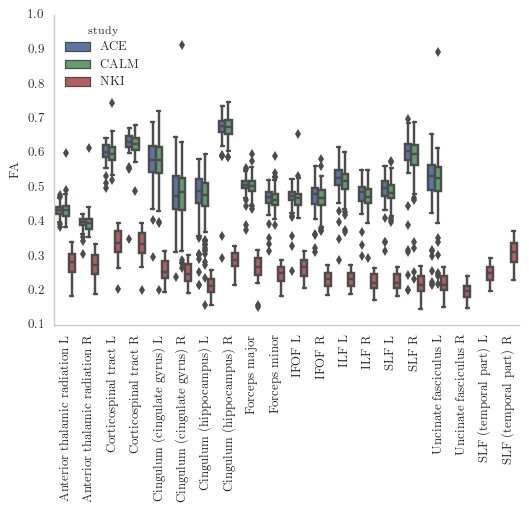

In [194]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

sns.boxplot(x='tract', y='FA', hue='study', data=results)
plt.xlabel(' ')
ax = plt.gca()
ax.set_xticklabels(labels, rotation='90')
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [195]:
lm = smf.ols('FA ~ C(tract) + C(study) + C(tract)*C(study)', data=results).fit()
sm.stats.anova_lm(lm, type=2).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
C(tract),19,31.422,1.654,877.990,0
C(study),2,65.702,32.851,17440.335,0
C(tract):C(study),38,4.127,0.109,57.664,0
Residual,6169,11.620,0.002,NaN,NaN


**Conclusion**: There is a systematic difference in FA between the studies

## 3. Feature variation

In [75]:
def get_feature_variance(df):
    feature_variance = pd.DataFrame(df.groupby('tract')['FA'].apply(np.var))
    feature_variance.index = labels
    feature_variance = feature_variance.sort_values(by='FA', ascending=False)
    
    sns.set_style("ticks")
    sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})
    plt.figure(figsize=(single_column, single_column), dpi=300)
    
    sns.barplot(x=feature_variance.index, y='FA', data=feature_variance, palette='Reds_r')
    sns.despine(offset=8, trim=True)
    plt.ylabel('variance')
    ax = plt.gca()
    ax.set_xticklabels(feature_variance.index, rotation='90');
    ax.set_axis_bgcolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    
    return feature_variance

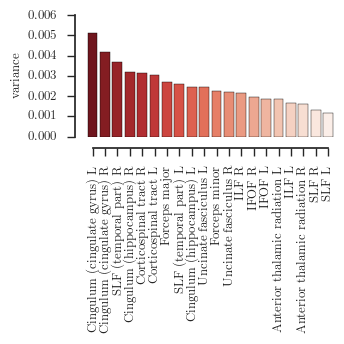

In [76]:
nki_variance = get_feature_variance(nki_results)
plt.savefig('../results/figures/NKI_variance.png', dpi=300)

## 4. Consensus clustering

In [359]:
def gather(df):
    
    newdf= pd.DataFrame()
    for counter in np.unique(df['tract']):
        newdf[counter] = df[df['tract'] == counter].groupby('ID')['FA'].mean()

    newdf.index = np.unique(df[df['tract'] == counter]['ID'])
    return newdf

def get_community_clustering(results):
    results[results.columns] = results.apply(zscore)
    correlation_matrix = results.transpose().corr().values
    community_affiliation,q = get_consensus_module_assignment(correlation_matrix, 100)
    
    return correlation_matrix, community_affiliation, q

def group_difference_overview(results, communities):
    new = results.copy()
    new[new.columns] = new.apply(zscore)
    new['groups'] = communities
    new = pd.melt(new, id_vars='groups')
    new.columns = ['groups', 'tract', 'FA']
    colours = ['darkorange', 'gold', 'aqua']
    counter = 0
    
    sns.set_style("ticks")
    sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})
    
    plt.figure(figsize=(one_half_column/2 + 1, one_half_column), dpi=300)
    for group in np.unique(new['groups']):
        temp_df = new.copy()
        temp_df = temp_df[temp_df['groups'] == group]
        means = temp_df.groupby('tract')['FA'].mean().values
        SEs = temp_df.groupby('tract')['FA'].apply(sem).values
        xs = np.arange(1, len(np.unique(temp_df['tract']))+1)
        plt.errorbar(x=xs, y=means, yerr=2*SEs, color=colours[counter])
        counter += 1
        
    sns.despine(offset=10, trim=True)
    plt.xlim(-1, len(np.unique(new['tract'])) + 1)
    plt.ylim([-1, 1.5])
    plt.ylabel('FA [zscore]')
    ax = plt.gca()
    ax.set_xticks(np.arange(1, len(np.unique(new['tract']))+1))
    ax.set_xticklabels(labels, rotation='90');
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.legend(['C' + str(i) for i in np.unique(new['groups'])])
    plt.tight_layout()

def determine_groups(other_df, region):
    minimum = np.mean(nki_df[all_communities == 1][region]) - sem(nki_df[all_communities == 1][region])
    maximum = np.mean(nki_df[all_communities == 2][region]) + sem(nki_df[all_communities == 2][region])

    new_df = pd.DataFrame(index=other_df.index, data={'value': other_df[region].values, 
                            'group': 2*(other_df[region].values > minimum) + 1*(other_df[region].values < maximum)})
    return new_df

def compare_other_groups(df):
    # Getting the group assignment with reference to the NKI grouping
    new_df1 = determine_groups(df, 'Cingulum (cingulate gyrus) L')
    new_df1['region'] = np.repeat('Cing L', new_df1.shape[0])
    new_df2 = determine_groups(df, 'Cingulum (cingulate gyrus) R')
    new_df2['region'] = np.repeat('Cing R', new_df2.shape[0])
    plot_df = pd.concat([new_df1[['value','region', 'group']], new_df2[['value', 'region', 'group']]])
        
    # Plotting the distribution of values
    sns.set_style("ticks")
    sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})
    my_palette = sns.color_palette(['#FF8C00', '#FFD700', '#D3D3D3'])

    plt.figure(figsize=(1.5, 0.6*one_half_column), dpi=300)
    sns.stripplot(x='region', y='value', hue='group', data=plot_df,
                  split=False, jitter=True, size=5, palette=my_palette)
    plt.ylim([-.16, .16])
    sns.despine(offset=10, trim=True)
    plt.xlabel(' ')
    plt.ylabel(' ')
    ax = plt.gca()
    ax.legend_.remove()
    ax.set_xticks(np.arange(0, len(np.unique(plot_df['region']))))
    ax.set_xticklabels(np.unique(plot_df['region']), rotation='90');
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.tight_layout()
    
    # Compare proportion of groups statistically
    for region in ['Cing L', 'Cing R']:
        observed = plot_df.groupby('region')['group'].value_counts()[region].sort_index().values[1:]
        expected = np.repeat(np.sum(observed)/2, 2)
        chi,p = chisquare(observed, expected)
        print('Results of chi-square comparison: chi=%.2f, p=%.3f' % (chi, p))
        
    return plot_df

def get_within_and_between_strength(correlation_matrix, all_communities):
    intra_corr = []
    for group in np.unique(all_communities):
        intra_correlations = correlation_matrix.copy()
        intra_correlations = np.squeeze(intra_correlations[np.where(all_communities == group), :])
        intra_correlations = np.squeeze(intra_correlations[:, np.where(all_communities == group)])
        intra_corr.append(np.sum(intra_correlations))
    intra_corr = np.mean(intra_corr)

    groups = np.unique(all_communities)
    inter_correlations = correlation_matrix.copy()
    inter_correlations = np.squeeze(inter_correlations[np.where(all_communities == groups[0]), :])
    inter_correlations = np.squeeze(inter_correlations[:, np.where(all_communities == groups[1])])
    inter_corr = np.sum(inter_correlations)
    
    return intra_corr, inter_corr

def test_group_assignment(correlation_matrix, all_communities):
    permutation_sample = []
    intra_corr, inter_corr = get_within_and_between_strength(correlation_matrix, all_communities)

    for i in np.arange(0,1000):
        random_communities = all_communities.copy()
        np.random.shuffle(random_communities)
        permutation_sample.append(get_within_and_between_strength(correlation_matrix, random_communities))

    random_intra_correlation = np.asarray(permutation_sample)[:, 0]
    random_inter_correlation = np.asarray(permutation_sample)[:, 1]

    intra_p = float(len(np.where(intra_corr <  random_intra_correlation)))/len(random_intra_correlation)
    inter_p = float(len(np.where(inter_corr >  random_inter_correlation)))/len(random_intra_correlation)
    
    
    print('Observed intra-correlation: %.2f' % intra_corr)
    print('Observed inter-correlation: %.2f' % inter_corr)
    print('intra-correlation vs random: %.3f' % intra_p)
    print('inter-correlation vs random: %.3f' % inter_p)

Regressing age from the tract values

In [197]:
def regress_age_effect(df, details):
    df = gather(df)
    df.columns = labels
    df['Age'] = details['Age'].values

    for tract in df.columns[:-1]:
        df[tract] = smf.ols('y ~ X', data=pd.DataFrame({'y':df[tract].values, 'X':df['Age'].values})).fit().resid.values
    
    return df

In [218]:
ace_df = regress_age_effect(ace_results, ace_details)
ace_df['study'] = np.repeat('ace', len(ace_df.index))

calm_df = regress_age_effect(calm_results, calm_details)
calm_df['study'] = np.repeat('calm', len(calm_df.index))

nki_df = regress_age_effect(nki_results, nki_details)
nki_df['study'] = np.repeat('nki', len(nki_df.index))

Saving the NKI results to do robustness tests further down

In [80]:
nki_df.to_csv('../results/NKI_age_regressed.csv', index=True, index_label='MRI.ID')

Running community clustering to create a grouping based on the age-regressed FA values within the tract

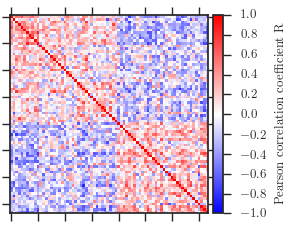

In [270]:
correlation_matrix, all_communities, all_q = get_community_clustering(nki_df[nki_df.columns[1:-2]])
plot_community_matrix(correlation_matrix, all_communities)
#plt.savefig('../results/figures/NKI_adjmat.png', dpi=300)

Creating a spring layout plot

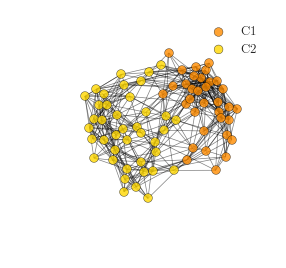

In [113]:
plot_spring_layout(nki_df[nki_df.columns[1:-2]], all_communities, 0.3)
#plt.savefig('../results/figures/NKI_spring_layout.png', dpi=300)

spring plot QQR

In [118]:
nki_df = pd.read_csv('../results/NKI_age_regressed.csv')
results = nki_df[nki_df.columns[1:-2]]
communities = all_communities

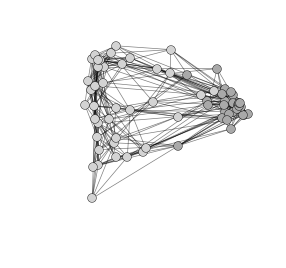

In [140]:
import bct
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.stats import zscore

results[results.columns] = results.apply(zscore)
correlation_matrix = results.transpose().corr().values

plt.figure(figsize=(one_half_column/2, one_half_column/2), dpi=300)
G=nx.from_numpy_matrix(bct.threshold_absolute(correlation_matrix, 0.3))
colours = ['#A9A9A9', '#D3D3D3']

pos=nx.spectral_layout(G)

for community in np.unique(communities):

    nx.draw_networkx_nodes(G,pos,
                           nodelist=np.where(communities == community)[0].tolist(),
                           node_color=colours[community-1],
                           node_size=40,
                           alpha=1)


nx.draw_networkx_edges(G,pos,width=0.5,alpha=0.5)
plt.axis('off');
plt.savefig('../results/figures/NKI_spring_layout_QQR.png', dpi=600)

Comparing the groups on age

In [83]:
nki_details['group'] = all_communities
mean = nki_details.groupby('group')['Age'].mean().values
SE = nki_details.groupby('group')['Age'].apply(sem).values
print('C1: mean=%.3f, SE=%.2f; C2: mean=%.2f, SE=%.3f ' % (mean[0], SE[0], mean[1], SE[1]))

t,p = ttest_ind(nki_details[nki_details['group'] == 1]['Age'], nki_details[nki_details['group'] == 2]['Age'])
df = nki_details.shape[0] - 2
print('t-test: t(%i)=%.2f, p=%.3f' % (df, t, p))

C1: mean=13.568, SE=0.59; C2: mean=14.23, SE=0.470 
t-test: t(72)=-0.89, p=0.375


Comparing the groups on gender

In [84]:
for group in [1,2]:
    gender_counts = nki_details[nki_details['group'] == group]['Gender'].value_counts().values.astype('float')
    observed_proportion = gender_counts/len(nki_details[nki_details['group'] == 1])
    expected_proportion = nki_details['Gender'].value_counts().values.astype('float')/len(nki_details['Gender'])
    chi, p = chisquare(observed_proportion, expected_proportion)

    print('Number of males: ' + str(gender_counts[0]))
    print('Number of females: ' + str(gender_counts[1]))
    print('Chi-square test: chi=%.2f, p=%.3f' % (chi,p))

Number of males: 24.0
Number of females: 10.0
Chi-square test: chi=0.06, p=0.800
Number of males: 21.0
Number of females: 19.0
Chi-square test: chi=0.05, p=0.825


Creating a plot of differences between the data-driven groups in tract values

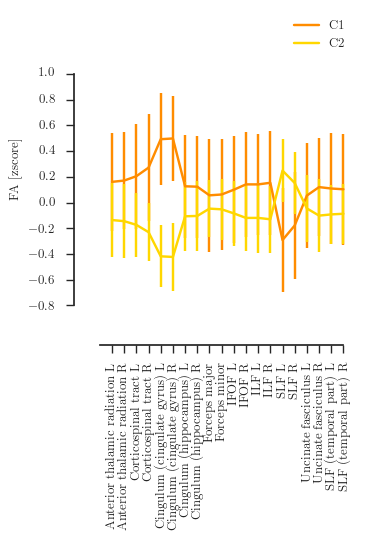

In [85]:
group_difference_overview(nki_df[nki_df.columns[:-2]], all_communities)
#plt.savefig('../results/figures/NKI_grouping.png', dpi=300)

p-values for the comparison between the clusters with Bonferroni correction

In [387]:
pvalues = []

for region in nki_df.columns[:-2]:
    group1 = nki_df[region][all_communities == 1]
    group2 = nki_df[region][all_communities == 2]
    print('Shapiro: C1: p=%.3f, C2: p=%.3f' % (shapiro(group1)[1], shapiro(group2)[1]))
    pvalues.append(mannwhitneyu(group1, group2)[1])

Shapiro: C1: p=0.016, C2: p=0.093
Shapiro: C1: p=0.024, C2: p=0.018
Shapiro: C1: p=0.000, C2: p=0.019
Shapiro: C1: p=0.000, C2: p=0.006
Shapiro: C1: p=0.021, C2: p=0.081
Shapiro: C1: p=0.082, C2: p=0.542
Shapiro: C1: p=0.013, C2: p=0.706
Shapiro: C1: p=0.066, C2: p=0.636
Shapiro: C1: p=0.000, C2: p=0.873
Shapiro: C1: p=0.000, C2: p=0.114
Shapiro: C1: p=0.001, C2: p=0.013
Shapiro: C1: p=0.003, C2: p=0.030
Shapiro: C1: p=0.005, C2: p=0.692
Shapiro: C1: p=0.005, C2: p=0.521
Shapiro: C1: p=0.008, C2: p=0.152
Shapiro: C1: p=0.032, C2: p=0.049
Shapiro: C1: p=0.004, C2: p=0.021
Shapiro: C1: p=0.003, C2: p=0.158
Shapiro: C1: p=0.001, C2: p=0.303
Shapiro: C1: p=0.031, C2: p=0.033


In [388]:
for region in np.where(corrected_pvalues < 0.05)[0]:
    group1 = zscore(nki_df[nki_df.columns[region]])[all_communities == 1]
    group2 = zscore(nki_df[nki_df.columns[region]])[all_communities == 2]
    U,p = mannwhitneyu(group1, group2)
    print('C1: mean=%.2f, SE=%.3f, C2: mean=%.2f, SE=%.3f' % (np.mean(group1), sem(group1), np.mean(group2), sem(group2)))
    print('Man-Whitney: U=%i p=%.3f, p_corr=%.3f' % (U, p, corrected_pvalues[region]))

C1: mean=0.49, SE=0.179, C2: mean=-0.42, SE=0.121
Man-Whitney: U=304 p=0.000, p_corr=0.000
C1: mean=0.50, SE=0.167, C2: mean=-0.42, SE=0.132
Man-Whitney: U=300 p=0.000, p_corr=0.000


***Comparing the grouping in the other samples***

First, the data from the other samples (CALM, ACE) is grouped according the cut-offs identified in the NKI sample. The colours are assigned according to the figure above, i.e. C1 orange, C2 yellow, and grey for neither. The percentage participants assigned to C1 or C2 in each sample is also plotted below. 

ACE

Results of chi-square comparison: chi=14.63, p=0.000
Results of chi-square comparison: chi=13.58, p=0.000


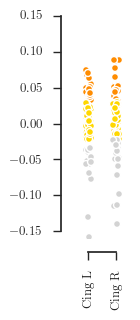

In [323]:
ace_grouped = compare_other_groups(ace_df)
ace_grouped.to_csv('../data/derived_data/ACE_grouped.csv')
plt.savefig('../results/figures/ACE_grouping.png', dpi=300)

In [324]:
ace_grouped[ace_grouped['region'] == 'Cing L']['group'].value_counts()

3    51
2    19
1    16
Name: group, dtype: int64

In [325]:
100*ace_grouped[ace_grouped['region'] == 'Cing L']['group'].value_counts()/len(ace_grouped[ace_grouped['region'] == 'Cing L'])

3    59.302326
2    22.093023
1    18.604651
Name: group, dtype: float64

In [360]:
ace_correlation_matrix = ace_df[ace_df.columns[:-2]].transpose().corr().values
ace_communities = pd.read_csv('../data/derived_data/ACE_grouped.csv')
ace_communities = ace_communities[ace_communities['region'] == 'Cing L']
ace_communities = ace_communities['group'].values
test_group_assignment(ace_correlation_matrix, ace_communities)

Observed intra-correlation: 64.85
Observed inter-correlation: -58.95
intra-correlation vs random: 0.001
inter-correlation vs random: 0.001


CALM

Results of chi-square comparison: chi=0.35, p=0.553
Results of chi-square comparison: chi=1.77, p=0.184


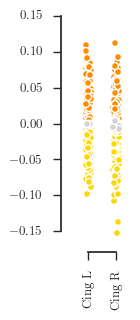

In [143]:
calm_grouped = compare_other_groups(calm_df)
calm_grouped.to_csv('../data/derived_data/CALM_grouped.csv')
plt.savefig('../results/figures/CALM_grouping.png', dpi=300)

**Conclusion**: Most participants in the CALM and ACE sample fall in the range of C1 and C2 defined in the NKI sample.

In [144]:
calm_grouped[calm_grouped['region'] == 'Cing L']['group'].value_counts()

2    95
1    87
0    11
Name: group, dtype: int64

In [145]:
100*calm_grouped[calm_grouped['region'] == 'Cing L']['group'].value_counts()/len(calm_grouped[calm_grouped['region'] == 'Cing L'])

2    49.222798
1    45.077720
0     5.699482
Name: group, dtype: float64

In [151]:
chisquare(f_obs=[0.49, 0.45], f_exp=[.5, .5])

Power_divergenceResult(statistic=0.005199999999999998, pvalue=0.94251355198275677)

In [361]:
calm_correlation_matrix = calm_df[calm_df.columns[:-2]].transpose().corr().values
calm_communities = pd.read_csv('../data/derived_data/CALM_grouped.csv')
calm_communities = calm_communities[calm_communities['region'] == 'Cing L']
calm_communities = calm_communities['group'].values
test_group_assignment(calm_correlation_matrix, calm_communities)

Observed intra-correlation: 521.17
Observed inter-correlation: 21.10
intra-correlation vs random: 0.001
inter-correlation vs random: 0.001


### 4.1 Testing the robustness of the community clustering solution

... by selecting random subsets of the NKI sample and running the algorithm again

Loading the age-regressed NKI values again

In [513]:
nki_df = pd.read_csv('../results/NKI_age_regressed.csv').set_index('MRI.ID')

Same code as above minus the plot:

In [420]:
def get_community_clustering(results):
    results[results.columns] = results.apply(zscore)
    correlation_matrix = results.transpose().corr().values
    community_affiliation,q = get_consensus_module_assignment(correlation_matrix, 100)

    return community_affiliation, q

The robustness is tested by selecting random subsets of the data of varying size (between 10% and 100%) and then applying the community clustering to this subset. This is repeated 20 times to estimate the confidence intervals at each size. The outcome of interest is the results of the statistical comparison of cingulum integrity between the groups and the quality index of the grouping.

In [597]:
results = []

for fraction in np.arange(0.1, 1.1, 0.1):
    number_of_communities = []
    quality_indices = []
    left_ps = []
    right_ps = []
    
    for i in np.arange(0, 20):
        random_subset = np.random.choice(nki_df.index, int(fraction*len(nki_df.index)))
        temp_df = nki_df.copy()
        temp_df = temp_df[temp_df.index.isin(random_subset)]
        communities, q = get_community_clustering(temp_df[temp_df.columns[:-2]])
        temp_df['group'] = communities
        lm = ols('y ~ C(X)', data=pd.DataFrame({'y':temp_df['Cingulum (cingulate gyrus) L'].values, 'X':temp_df['group'].values})).fit()
        left_p = sm.stats.anova_lm(lm, typ=2)['PR(>F)'][0]
        lm = ols('y ~ C(X)', data=pd.DataFrame({'y':temp_df['Cingulum (cingulate gyrus) R'].values, 'X':temp_df['group'].values})).fit()
        right_p = sm.stats.anova_lm(lm, typ=2)['PR(>F)'][0]
        
        left_ps.append(left_p)
        right_ps.append(right_p)
        number_of_communities.append(len(np.unique(communities)))
        quality_indices.append(q)

    results.append({'fraction': fraction,
                    'left_p': np.mean(left_ps),
                    'left_p_SE': sem(left_ps),
                    'right_p': np.mean(right_ps),
                    'right_p_SE': sem(right_ps),
                    'communities': np.mean(number_of_communities),
                    'communities_SE': sem(number_of_communities),
                    'quality_index': np.mean(quality_indices),
                    'quality_index_SE': sem(quality_indices)})

Summarizing the results in pretty figure

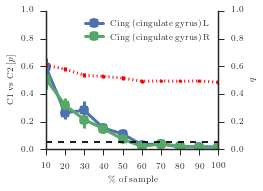

In [609]:
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

temp_df = pd.DataFrame(results)    
fig, ax1 = plt.subplots(figsize=(one_half_column/2 + 1, one_half_column/2), dpi=300)
ax1.errorbar(x=100*temp_df['fraction'], y=temp_df['left_p'], yerr=temp_df['left_p_SE'], 
             linewidth=3, marker='o', markersize=10)
ax1.errorbar(x=100*temp_df['fraction'], y=temp_df['right_p'], yerr=temp_df['right_p_SE'],
             linewidth=3, marker='o', markersize=10)
ax1.set_xlabel(r'\% of sample')
ax1.set_ylabel(r'C1 vs C2 [$p$]')
plt.ylim([0, 1])
plt.legend(['Cing (cingulate gyrus) L', 'Cing (cingulate gyrus) R'])
plt.axhline(0.05, 0, 1, color='k', linestyle='dashed')

ax2 = ax1.twinx()
ax2.errorbar(x=100*temp_df['fraction'], y=temp_df['quality_index'], yerr=temp_df['quality_index_SE'], 
             color='r', linestyle='dotted', linewidth=3, marker='o', markersize=3)
ax2.set_ylabel(r'$q$')
plt.ylim([0, 1])

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tight_layout()
plt.savefig('../results/figures/NKI_robustness.png', dpi=300)

### 5. Comparing the groups on behavioural measures

### CALM

Loading the data

In [8]:
calm_grouped = pd.read_csv('../data/derived_data/CALM_grouped.csv')
calm_grouped = calm_grouped.set_index('Unnamed: 0')
calm_behaviour = pd.read_csv('../data/raw_data/CALM_behavioural_data_Apr17.csv')
calm_behaviour = calm_behaviour[calm_behaviour['ID No.'].isin(calm_behaviour['ID No.'].dropna())]
calm_behaviour['MRI.ID'] = [get_imaging_ID(str(int(ID)), '../data/raw_data/MRI_ID_match_Aug17.csv') for ID in calm_behaviour['ID No.']]
measures = ['Matrix_Reasoning_Raw', 'PPVT_Raw', 'AWMA_Digit_Recall_Raw', 'AWMA_Dot_Matrix_Raw', 'AWMA_Backward_Digit__Raw', 'AWMA_Mr_X__Raw', 'CMS_delayed_raw']
calm_behaviour = calm_behaviour[np.hstack([['MRI.ID', 'Age_in_months'], measures])]
calm_behaviour = calm_behaviour.dropna()
calm_behaviour = calm_behaviour[calm_behaviour['MRI.ID'].isin(calm_grouped.index)]
calm_behaviour = calm_behaviour.set_index('MRI.ID')
calm_behaviour[np.hstack(['Age_in_months', measures])] = zscore(calm_behaviour[np.hstack(['Age_in_months', measures])])
calm_behaviour = pd.merge(calm_behaviour, calm_grouped, left_index=True, right_index=True)

In [9]:
ps = list()

for measure in measures:
    group1 = calm_behaviour[calm_behaviour['group'] == 1][measure].values
    group2 = calm_behaviour[calm_behaviour['group'] == 2][measure].values
    t,p = mannwhitneyu(group1, group2)
    ps.append(p)
    
binarized_results,corrected_ps,_,_ = multipletests(ps, method='bonferroni')

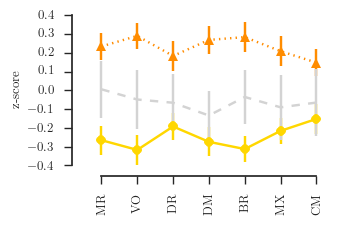

In [89]:
# Plotting the distribution of values
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
           'font.family': [u'serif'],
           'font.sans-serif': [u'Computer Modern Unicode'],})
style = [['#D3D3D3', 'x', 'dashed'], ['#FFD700', 'o', 'solid'], ['#FF8C00', '^', 'dotted']]
plt.figure(figsize=(90*mm2inches, 60*mm2inches), dpi=600)
    
for group in [2,1,0]:
    x = np.arange(0,len(measures))
    y = calm_behaviour[calm_behaviour['group'] == group][measures].mean().values
    yerr = calm_behaviour[calm_behaviour['group'] == group][measures].apply(sem).values
    plt.errorbar(x, y, yerr, color=style[group][0], marker=style[group][1], linestyle=style[group][2])
        
sns.despine(offset=8, trim=True)
plt.ylabel('z-score')    
#plt.legend(['C' + str(community) for community in [1,2,0]], frameon=True, loc='best')
plt.xlim([-0.5,len(measures)-0.5])
plt.xticks(range(0,len(measures)))
ax = plt.gca()
ax.set_xticklabels('', rotation=90);
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels(['MR','VO','DR','DM','BR','MX','CM'], rotation=90);
plt.tight_layout()
plt.savefig('../results/figures/CALM_group_comparison.png', dpi=600)

QQR plot

In [161]:
calm_grouped = pd.read_csv('../data/derived_data/CALM_grouped.csv')
calm_grouped = calm_grouped[calm_grouped['group'].isin([1, 2])]
calm_grouped['group'] = pd.Categorical(calm_grouped['group'], categories=[1,2])
calm_grouped = calm_grouped[calm_grouped['region'] == 'Cing L']
calm_grouped['value'] = zscore(calm_grouped['value'])

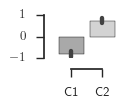

In [168]:
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
           'font.family': [u'sans-serif'],
           'font.sans-serif': [u'Verdana'],})
mypal = sns.color_palette(['#A9A9A9', '#D3D3D3'])

plt.figure(figsize=(35*mm2inches, 30*mm2inches), dpi=600)
sns.barplot(x='group', y='value', palette=mypal, data=calm_grouped)
sns.despine(offset=8, trim=True)
ax = plt.gca()
ax.set_yticks(np.linspace(-1, 1, 3))
ax.set_xticklabels(['C1', 'C2'])
plt.xlabel(' ')
plt.ylabel(' ')
plt.tight_layout()
plt.savefig('./QQR_plot.png', dpi=600)

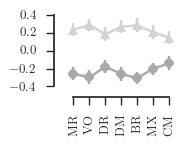

In [81]:
# Plotting the distribution of values
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
           'font.family': [u'serif'],
           'font.sans-serif': [u'Computer Modern Unicode'],})
style = [['#A9A9A9', 'x', 'dashed'], ['#A9A9A9', 'o', 'solid'], ['#D3D3D3', '^', 'solid']]
plt.figure(figsize=(50*mm2inches, 40*mm2inches), dpi=600)
    
for group in [2,1,0]:
    x = np.arange(0,len(measures))
    y = calm_behaviour[calm_behaviour['group'] == group][measures].mean().values
    yerr = calm_behaviour[calm_behaviour['group'] == group][measures].apply(sem).values
    plt.errorbar(x, y, yerr, color=style[group][0], marker=style[group][1], linestyle=style[group][2])
        
sns.despine(offset=8, trim=True)
plt.ylabel(' ')    
plt.xlim([-0.5,len(measures)-0.5])
plt.xticks(range(0,len(measures)))
ax = plt.gca()
ax.set_xticklabels('', rotation=90);
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_yticks(np.linspace(-0.4, 0.4, 5))
ax.set_xticklabels(['MR','VO','DR','DM','BR','MX','CM'], rotation=90);
plt.tight_layout()
plt.savefig('../results/figures/CALM_group_comparison_QQR.png', dpi=600)

### ACE 

In [92]:
ace_grouped = pd.read_csv('../data/derived_data/ACE_grouped.csv')
ace_grouped = ace_grouped.set_index('Unnamed: 0')
ace_behaviour = pd.read_csv('../data/raw_data/ACE_behavioural_data.csv')
measures = ['WASI_Vocab', 'WASI_Mat', 'WM_DR_raw', 'WM_DM_raw', 'WM_BD_raw', 'WM_MX_raw']
ace_behaviour = ace_behaviour[np.hstack([['MRI.ID'], measures])]
ace_behaviour = ace_behaviour.set_index('MRI.ID')
ace_behaviour = ace_behaviour.dropna()
ace_behaviour[measures] = ace_behaviour[measures].apply(zscore)
ace_behaviour = pd.merge(ace_grouped, ace_behaviour, left_index=True, right_index=True)
ace_demographics = pd.read_csv('../data/raw_data/ACE_demographic_data.csv')
ace_demographics = ace_demographics.set_index('MRI.ID')
ace_behaviour = pd.merge(ace_behaviour, ace_demographics, left_index=True, right_index=True)

In [93]:
ps = list()

for measure in measures:
    group1 = ace_behaviour[ace_behaviour['group'] == 1][measure].values
    group2 = ace_behaviour[ace_behaviour['group'] == 2][measure].values
    t,p = mannwhitneyu(group1, group2)
    ps.append(p)
    
binarized_results,corrected_ps,_,_ = multipletests(ps, method='bonferroni')

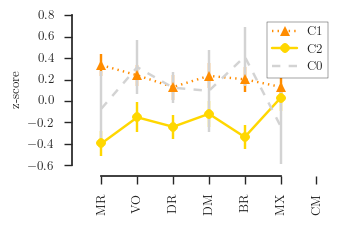

In [99]:
# Plotting the distribution of values
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
           'font.family': [u'serif'],
           'font.sans-serif': [u'Computer Modern Unicode'],})
style = [['#D3D3D3', 'x', 'dashed'], ['#FFD700', 'o', 'solid'], ['#FF8C00', '^', 'dotted']]
plt.figure(figsize=(90*mm2inches, 60*mm2inches), dpi=600)
    
for group in [2,1,0]:
    x = np.arange(0,len(measures))
    y = ace_behaviour[ace_behaviour['group'] == group][measures].mean().values
    yerr = ace_behaviour[ace_behaviour['group'] == group][measures].apply(sem).values
    plt.errorbar(x, y, yerr, color=style[group][0], marker=style[group][1], linestyle=style[group][2])
        
sns.despine(offset=8, trim=True)

plt.ylabel('z-score')    
plt.legend(['C' + str(community) for community in [1,2,0]], frameon=True, loc='best')
plt.xlim([-0.5,len(measures)+1-0.5])
plt.xticks(range(0,len(measures)+1))
ax = plt.gca()
ax.set_xticklabels('', rotation=90);
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels(['MR','VO','DR','DM','BR','MX','CM'], rotation=90);
plt.tight_layout()
plt.savefig('../results/figures/ACE_group_comparison.png', dpi=600)

In [101]:
np.asarray(ps).round(3)

array([ 0.   ,  0.005,  0.007,  0.007,  0.001,  0.207])

In [95]:
corrected_ps.round(3)

array([ 0.   ,  0.028,  0.043,  0.044,  0.003,  1.   ])

#### Characterising the sample with age-normed scores

In [113]:
calm_grouped = pd.read_csv('../data/derived_data/CALM_grouped.csv')
calm_grouped = calm_grouped.set_index('Unnamed: 0')
calm_behaviour = pd.read_csv('../data/raw_data/CALM_behavioural_data_Apr17.csv')
calm_behaviour = calm_behaviour[calm_behaviour['ID No.'].isin(calm_behaviour['ID No.'].dropna())]
calm_behaviour['MRI.ID'] = [get_imaging_ID(str(int(ID)), '../data/raw_data/MRI_ID_match_Aug17.csv') for ID in calm_behaviour['ID No.']]
measures = ['Matrix_Reasoning_T', 'PPVT_Std', 'AWMA_Digit_Recall_Standard', 'AWMA_Dot_Matrix_Standard', 'AWMA_Backward_Digit__Standard', 'AWMA_Mr_X__Standard', 'CMS_delayed_Scaled']
calm_behaviour = calm_behaviour[np.hstack([['MRI.ID', 'Age_in_months'], measures])]
calm_behaviour = calm_behaviour.dropna()
calm_behaviour = calm_behaviour[calm_behaviour['MRI.ID'].isin(calm_grouped.index)]
calm_behaviour = calm_behaviour.set_index('MRI.ID')
calm_behaviour = pd.merge(calm_behaviour, calm_grouped, left_index=True, right_index=True)

Transforming all measures to the same scale by zscoring them to the mean and standard deviation of the normative sample

In [117]:
calm_behaviour['Matrix_Reasoning_T'] = (calm_behaviour['Matrix_Reasoning_T']-50)/10
for measure in ['PPVT_Std', 'AWMA_Digit_Recall_Standard', 'AWMA_Dot_Matrix_Standard', 'AWMA_Backward_Digit__Standard', 'AWMA_Mr_X__Standard']:
    calm_behaviour[measure] = (calm_behaviour[measure]-100)/15
calm_behaviour['CMS_delayed_Scaled'] = (calm_behaviour['CMS_delayed_Scaled']-10)/2

Age distribution plot

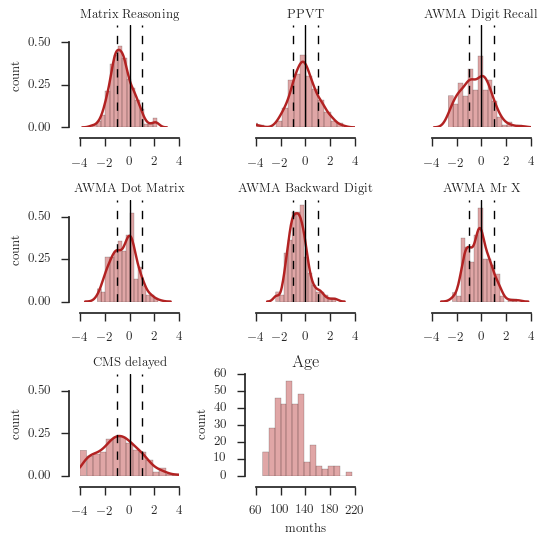

In [199]:
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.size': 9,
               'font.sans-serif': [u'Computer Modern Unicode'],})
fig, ax1 = plt.subplots(figsize=(one_half_column, one_half_column), dpi=300)
counter = 1

for measure in measures:
    plt.subplot(3, 3, counter)
    sns.distplot(calm_behaviour[measure].values, bins=15, color='firebrick')
    plt.axvline(0, color='k', linewidth=1)
    plt.axvline(1, color='k', linewidth=1, linestyle='dashed')
    plt.axvline(-1, color='k', linewidth=1, linestyle='dashed')
    plt.title(' '.join(measure.split('_')[:-1]), fontsize=9)
    ax = plt.gca()
    plt.ylabel('count')
    plt.xlim([-4, 4])
    plt.ylim([0, 0.6])
    ax.set_axis_bgcolor('white')
    ax.set_xticks(np.arange(-4, 6, 2))
    ax.set_yticks(np.arange(0, 0.75, 0.25))
    if counter not in [1,4,7]:
        ax.yaxis.set_visible(False)
        ax.set_yticks(np.arange(0, 0.5, 10))
    sns.despine(offset=8, trim=True)
    plt.tight_layout()
    counter += 1
    
plt.subplot(3, 3, 8)
sns.distplot(calm_behaviour['Age_in_months'].values, kde=False, bins=15, color='firebrick')
sns.despine(offset=8, trim=True)
plt.title('Age')
plt.xlabel('months')
plt.ylabel('count')
plt.tight_layout()
plt.gca().set_xticks(np.arange(60, 240, 40))
plt.savefig('../results/figures/cognitive_distributions.png', dpi=300)

### Testing the grouping

In [233]:
import bct

nki_df = pd.read_csv('../results/NKI_age_regressed.csv').set_index('MRI.ID')
matrix, communities1, q1 = get_community_clustering(nki_df[nki_df.columns[:-2]])
communities2, q2 = bct.modularity_finetune_und_sign(nki_df[nki_df.columns[:-2]].transpose().corr().values, qtype='neg')